# Exploratory Data Analysis (EDA)

### Author: hl-n

## Overview

This notebook focuses on exploring and understanding the dataset from the National Health and Nutrition Examination Survey (NHANES).<br>
The primary goal is to gain insights into the data distribution, identify patterns, and address any data preprocessing requirements before training the machine learning models to predict the presence of diabetes.

## Import Relevant Modules

In [1]:
import os

target_directory = "diabetes-prediction-NHANES"
if not os.path.exists(target_directory):
    os.chdir("..")
    
from src.data_preparation.data_ingestion import load_dataset
from src.data_preparation.metadata_retriever import fetch_metadata, infer_missing_metadata
from src.data_preparation.data_preprocessing import (
    rename_columns, index_by_identifier,
)
from src.data_preparation.data_processing import (
    create_target_variable, handle_missing_data,
    convert_range_to_min_max, convert_features_to_boolean,
    one_hot_encode_features, scale_numerical_features,
    upsample_minority, sort_columns
)
from src.utils.config_utils import load_config
from src.utils.file_utils import create_results_directory
from src.utils.results_plotting import (
    save_plot, add_annotations_to_bars, plot_heatmap,
    plot_distribution, plot_ratio_target_in_categorical_features
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

## Loading the Raw Dataset

Let's start by loading the raw dataset using the data ingestion module.<br>
The URL to the raw dataset and the file path to save it to are stored in the configuration file.

In [2]:
config_path = "config.yaml"
config = load_config(config_path=config_path)
raw_df = load_dataset(
    file_path=config.get("raw_dataset_path"),
    url=config.get("raw_dataset_url")
)
raw_df # Preview the DataFrame

,seqn,sex,age,re,income,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr
0,51624,male,34.166667,Non-Hispanic White,"[25000,35000)",0,0,87.4,164.7,32.22,41.5,40.0,36.4,100.4,16.4,24.9,5.2,4.8,6.0,0.94
1,51626,male,16.833333,Non-Hispanic Black,"[45000,55000)",0,0,72.3,181.3,22.00,42.0,39.5,26.6,74.7,10.2,10.5,5.7,4.6,9.0,0.89
2,51628,female,60.166667,Non-Hispanic Black,"[10000,15000)",1,1,116.8,166.0,42.39,35.3,39.0,42.2,118.2,29.6,35.6,6.0,3.9,10.0,1.11
3,51629,male,26.083333,Mexican American,"[25000,35000)",0,0,97.6,173.0,32.61,41.7,38.7,37.0,103.7,19.0,23.2,5.1,4.2,8.0,0.80
4,51630,female,49.666667,Non-Hispanic White,"[35000,45000)",0,0,86.7,168.4,30.57,37.5,36.1,33.3,107.8,30.3,28.0,5.3,4.3,13.0,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,62155,male,33.000000,Mexican American,"[35000,45000)",0,0,94.3,163.5,35.28,34.4,34.7,35.5,112.3,20.2,NaN,5.4,4.1,10.0,0.97
6791,62156,female,48.916667,Non-Hispanic White,"[0,5000)",0,1,87.1,156.9,35.38,33.9,34.5,37.0,99.4,28.6,25.4,5.5,4.1,7.0,0.89
6792,62157,male,27.500000,Other Hispanic,"[35000,45000)",0,0,57.0,164.3,21.12,35.3,33.7,29.6,73.2,4.2,6.8,5.6,4.5,11.0,0.94
6793,62158,male,75.750000,Non-Hispanic Black,"[10000,15000)",0,0,75.1,162.7,28.37,38.6,36.8,31.2,104.0,19.8,21.1,5.4,4.0,19.0,1.34


## Retrieve Metadata

Next, let's load the metadata.
The URL to the metadata and the file path to save it to are also stored in the config file.

In [3]:
metadata_df = fetch_metadata(url=config.get("metadata_url"), file_path=config.get("metadata_path"))
metadata_df # Preview the DataFrame

,Labels,Units,Levels,Class,Storage,NAs
Name,,,,,,
seqn,Respondent sequence number,NaN,NaN,integer,integer,0
sex,NaN,NaN,2.0,NaN,integer,0
age,Age,years,NaN,numeric,double,0
re,Race/Ethnicity,NaN,5.0,NaN,integer,0
income,Family Income,NaN,14.0,NaN,integer,320
tx,On Insulin or Diabetes Meds,NaN,NaN,integer,integer,0
dx,Diagnosed with DM or Pre-DM,NaN,NaN,integer,integer,0
wt,Weight,kg,NaN,numeric,double,0
ht,Standing Height,cm,NaN,numeric,double,0


## Clean Metadata

**Some** of the **metadata**, like the label and class for "sex", are **missing**.<br>
Let's see if we can **infer them**.

In [4]:
cleaned_metadata_df = infer_missing_metadata(raw_df, metadata_df, config)
metadata_df

,Labels,Units,Levels,Class,Storage,NAs
Name,,,,,,
seqn,Respondent sequence number,NaN,NaN,integer,integer,0
sex,Sex,NaN,2.0,categorical,integer,0
age,Age,years,NaN,numeric,double,0
re,Race/Ethnicity,NaN,5.0,categorical,integer,0
income,Family Income,NaN,14.0,categorical,integer,320
tx,On Insulin or Diabetes Meds,NaN,2.0,integer,integer,0
dx,Diagnosed with DM or Pre-DM,NaN,2.0,integer,integer,0
wt,Weight,kg,NaN,numeric,double,0
ht,Standing Height,cm,NaN,numeric,double,0


## Check if Raw Data and Metadata Match

### Verify if Data Types in Raw Data and Metadata Match

In [5]:
raw_df.dtypes[
    cleaned_metadata_df["Class"].replace({
        "integer": "int64",
        "numeric": "float64",
        pd.NA: "object"
    })!=raw_df.dtypes
]

sex        object
re         object
income     object
bun       float64
dtype: object

In [6]:
cleaned_metadata_df["Class"][
    cleaned_metadata_df["Class"].replace({
        "integer": "int64",
        "numeric": "float64",
        pd.NA: "object"
    })!=raw_df.dtypes
]

Name
sex       categorical
re        categorical
income    categorical
bun           integer
Name: Class, dtype: object

The blood urea nitrogen is the only feature that does not seem to match the data type given in the metadata. This discrepancy may be attributed to the presence of missing values, leading Pandas to assign the "float" type.

In [7]:
# Check if all values in "bun" are either missing or positive whole numbers
column_name = "bun"
np.all(
    (raw_df[column_name][raw_df[column_name].notna()].unique() % 1 == 0) &
    (raw_df[column_name][raw_df[column_name].notna()].unique() > 0)
)

True

All values for blood urea nitrogen are positive integers, except for the null values. This explains the inconsistency between the actual data type, which is inferred as "float" due to the presence of missing values, and the expected "integer" type specified in the metadata.

### Verify if Number of Categories in Raw Data and Metadata Matches

In [8]:
(   raw_df.nunique()[raw_df.nunique()<=config.get("max_num_categories")]==
    cleaned_metadata_df["Levels"][cleaned_metadata_df["Levels"].notna()]
).all()

True

### Verify if Missing Data in Raw Data and Metadata Matches

In [9]:
(cleaned_metadata_df["NAs"] == raw_df.isna().sum()).all()

True

The **raw data and metadata align** in reporting the total number of missing values for each feature,<br>
and the number of classes for the categorical variables,<br>
which suggests consistency and **reliability in the dataset**.

## Preprocess Data

### Replace Column Names in Raw Data with Labels from Metadata

Let's rename the column names for easier reference.

In [10]:
# Add escape character "\\" before the percentage symbol %" "to tell LaTeX to treat the "%" as a regular character.
cleaned_metadata_df["Units"] = cleaned_metadata_df["Units"].replace("%", "\\%")
cleaned_metadata_df

,Labels,Units,Levels,Class,Storage,NAs
Name,,,,,,
seqn,Respondent sequence number,NaN,NaN,integer,integer,0
sex,Sex,NaN,2.0,categorical,integer,0
age,Age,years,NaN,numeric,double,0
re,Race/Ethnicity,NaN,5.0,categorical,integer,0
income,Family Income,NaN,14.0,categorical,integer,320
tx,On Insulin or Diabetes Meds,NaN,2.0,integer,integer,0
dx,Diagnosed with DM or Pre-DM,NaN,2.0,integer,integer,0
wt,Weight,kg,NaN,numeric,double,0
ht,Standing Height,cm,NaN,numeric,double,0


In [11]:
# Rename column names with labels and units
preprocessed_df = raw_df.copy()
preprocessed_df = rename_columns(preprocessed_df, config)
pd.DataFrame([preprocessed_df.columns]).T.set_index(raw_df.columns)

,0
seqn,Respondent sequence number
sex,Sex
age,Age ($years$)
re,Race/Ethnicity
income,Family Income
tx,On Insulin or Diabetes Meds
dx,Diagnosed with DM or Pre-DM
wt,Weight ($kg$)
ht,Standing Height ($cm$)
bmi,Body Mass Index ($kg/m^2$)


### Verify if Identifier is Unique and Index by Identifier

Typically, **respondent sequence number** is intended as a **unique identifier** for each respondent.

In [12]:
preprocessed_df[config.get("unique_identifier")].nunique()==len(preprocessed_df)

True

Indeed, we see that is it unique.
Let's **index** the raw dataset **by the identifier**.

In [13]:
preprocessed_df = index_by_identifier(preprocessed_df, config)

## Identify and Visualise Missing Values

In [14]:
folder_path = create_results_directory(config, stage="EDA", folder_name="Missing Data")

### Plot Proportion of Missing Rows in Raw Data For Every Feature

In [15]:
preprocessed_df.isna().any(axis=1).mean()*100

21.368653421633553

The proportion of rows with missing data is around **21.4%**, which is **quite large**. <br>
Removing them entirely may lead to a significant loss of data and potentially introduce bias, especially if the missingness is not random.

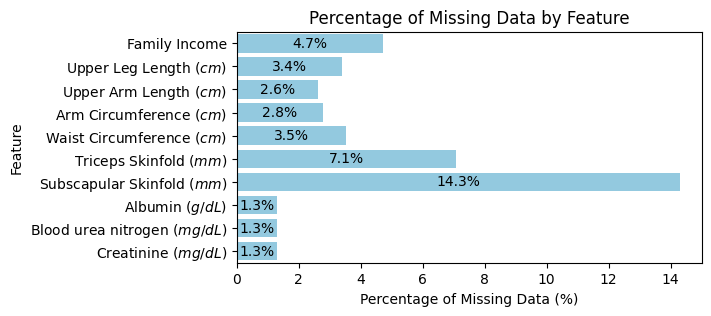

In [16]:
# Filter the data for only columns that contain missing values
columns_with_na = preprocessed_df.columns[preprocessed_df.isna().any()].to_list()
rows_with_na = preprocessed_df[columns_with_na].copy()
percentage_na = rows_with_na.isna().mean() * 100

# Plot Proportion of Missing Data by Feature
plt.figure(figsize=(6, 3))
xlabel = "Percentage of Missing Data (%)"
ylabel = "Feature"
plot_df = percentage_na.reset_index().rename(columns={0: xlabel, "index": ylabel})
ax = sns.barplot(y=ylabel, x=xlabel, data=plot_df, color="skyblue")
add_annotations_to_bars(ax=ax, x_shift=0)

title = "Percentage of Missing Data by Feature"
plt.title(title)
plt.xticks()
save_plot(folder_path, title)
plt.show()

**Observations:**

1. **Respondent Sequence Number, Sex, Age, Race/Ethnicity, Family Income, On Insulin or Diabetes Medications, Weight, Standing Height, Body Mass Index, and Glycohemoglobin:** These columns have **no missing data**.

2. **Albumin, Blood Urea Nitrogen, Creatinine, Family Income, Upper Leg Length, Upper Arm Length, Arm Circumference, and Waist Circumference:** These features have **less than 5% of missing values**. Imputation or removal may be considered based on the significance of these features.

3. **Triceps Skinfold, Subscapular Skinfold:** These features have a higher percentage of missing data (**7.1%** and **14.3%**, respectively). Careful consideration is needed, as **a substantial portion of the data is missing**.


### Check if Missingness is Random

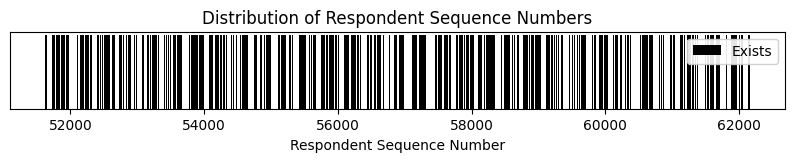

In [17]:
unique_identifier = config.get("unique_identifier")
seqn_range = range(preprocessed_df.index.min(), preprocessed_df.index.max() + 1)
plt.figure(figsize=(10, 1))
plt.bar(seqn_range, color=["black" if number in preprocessed_df.index.values else "w" for number in seqn_range], height=1)
plt.legend(["Exists"], loc="upper right", framealpha=0.9)
plt.xlabel(unique_identifier.title())
title = f'Distribution of {unique_identifier.title()}s'
plt.title(title)
plt.yticks([])  # Hide y-axis
save_plot(folder_path, title)
plt.show()

The distribution of unique identifiers appears to be evenly spread across the entire range, with no apparent clustering or accumulation of identifiers in specific regions. This uniform distribution is a positive sign, indicating a balanced allocation of identifiers without any bias or concentration.

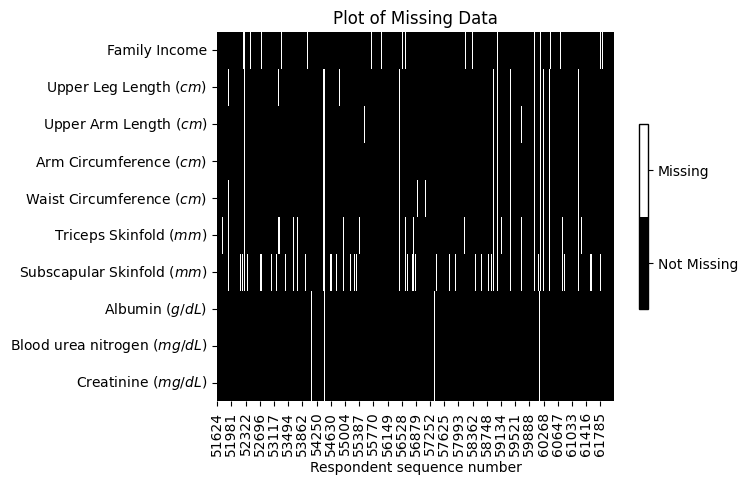

In [18]:
# Plot of Missing Data
colors = ["black", "w"] 
cmap = LinearSegmentedColormap.from_list("Custom", colors, len(colors))
ax = sns.heatmap(rows_with_na.isna().T, cmap=cmap, cbar_kws={"shrink": .5})
colorbar = ax.collections[0].colorbar; colorbar.set_ticks([0.25,0.75])
colorbar.set_ticklabels(["Not Missing", "Missing"])
colorbar.outline.set_edgecolor("black"); colorbar.outline.set_linewidth(1)
title = "Plot of Missing Data"
plt.title(title)
save_plot(folder_path, title)
plt.show()

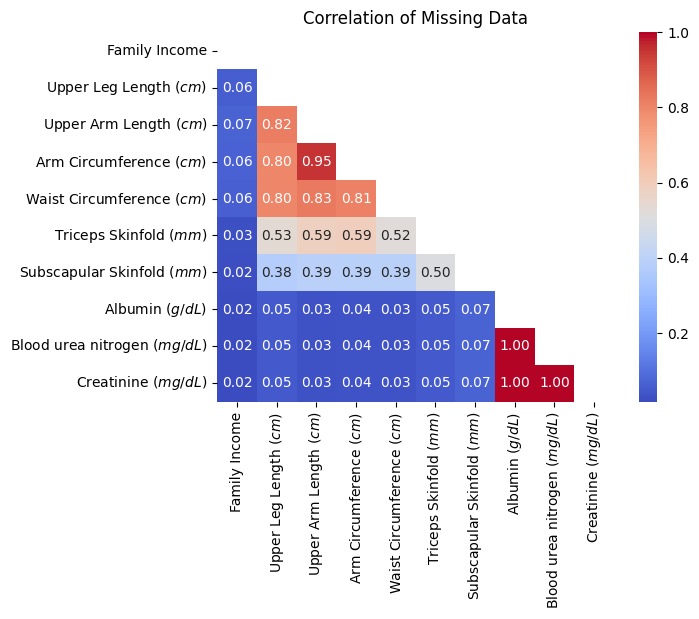

In [19]:
# Correlation of Missing Data

plot_heatmap(
    df=rows_with_na.isna().corr(),
    title="Correlation of Missing Data",
    num_dp=2
)

Observations:
1. Family Income has a relatively low correlation with other features, indicating its missingness may be independent of other variables.
2. Upper Leg Length and Upper Arm Length show a high positive correlation, indicating similar patterns of missingness.
3. Triceps Skinfold and Subscapular Skinfold exhibit a moderate positive correlation, suggesting some shared missingness patterns.
4. The variables Albumin, Blood Urea Nitrogen, and Creatinine have perfect positive correlations, indicating identical missingness patterns.


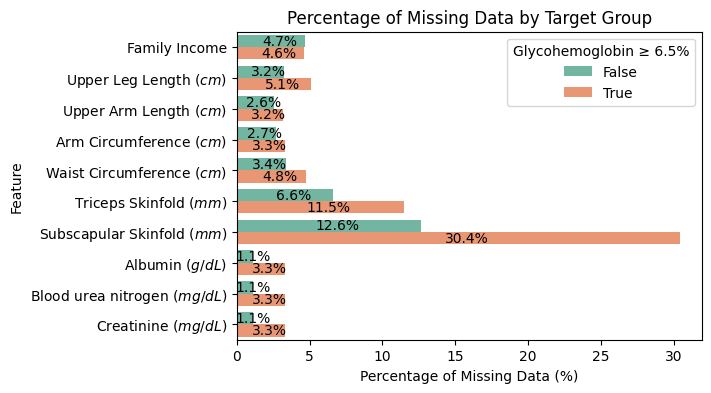

In [20]:
# Proportion of Missing Data by Target Group
target = config.get("target")
feature = config.get("feature")
rows_with_na_and_feat = preprocessed_df[columns_with_na + [feature]].copy()
rows_with_na_and_feat = create_target_variable(rows_with_na_and_feat, config)
percentage_na_by_target = rows_with_na_and_feat.drop(
    columns=[target, feature]
).groupby(rows_with_na_and_feat[target]).apply(lambda x: x.isna().mean()*100).T

# Plot Proportion of Missing Data by Target Group
plt.figure(figsize=(6, 4))
xlabel = "Percentage of Missing Data (%)"
plot_df = percentage_na_by_target.reset_index().melt(id_vars="index", var_name=target, value_name=xlabel)
colors = sns.color_palette("Set2", n_colors=2)
ax = sns.barplot(y="index", x=xlabel, hue=target, data=plot_df, palette=colors)

add_annotations_to_bars(ax=ax, x_shift=6)

title = "Percentage of Missing Data by Target Group"
plt.title(title)
plt.ylabel("Feature")
plt.legend(title=target)
plt.xticks()
save_plot(folder_path, title)
plt.show()

Some features, such as "Triceps Skinfold" and "Subscapular Skinfold," exhibit higher percentages of missing data in the target group with glycohemoglobin levels greater than or equal to 6.5%.<br>
This suggests potential systematic patterns in missing data concerning the target.

## Identify Outliers

In [21]:
preprocessed_df.describe()

,Age ($years$),On Insulin or Diabetes Meds,Diagnosed with DM or Pre-DM,Weight ($kg$),Standing Height ($cm$),Body Mass Index ($kg/m^2$),Upper Leg Length ($cm$),Upper Arm Length ($cm$),Arm Circumference ($cm$),Waist Circumference ($cm$),Triceps Skinfold ($mm$),Subscapular Skinfold ($mm$),Glycohemoglobin ($\%$),Albumin ($g/dL$),Blood urea nitrogen ($mg/dL$),Creatinine ($mg/dL$)
count,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6564.000000,6616.000000,6607.000000,6556.000000,6314.000000,5824.000000,6795.000000,6706.000000,6706.000000,6706.000000
mean,44.285700,0.091832,0.134511,79.370625,167.042958,28.321741,38.409324,36.874607,32.485152,96.254149,18.787726,19.961556,5.676586,4.273621,12.917686,0.878627
std,20.594593,0.288810,0.341225,21.930903,10.264984,6.950110,3.876902,2.781616,5.297660,17.059193,8.319393,8.369083,0.964700,0.326545,5.717571,0.445238
min,12.000000,0.000000,0.000000,28.000000,123.300000,13.180000,20.400000,24.800000,16.800000,52.000000,2.600000,3.800000,4.000000,2.500000,1.000000,0.140000
25%,25.666667,0.000000,0.000000,64.000000,159.600000,23.430000,36.000000,35.000000,28.850000,83.500000,12.000000,13.000000,5.200000,4.100000,9.000000,0.700000
50%,43.750000,0.000000,0.000000,76.300000,166.600000,27.290000,38.400000,36.800000,32.100000,95.300000,17.900000,19.400000,5.500000,4.300000,12.000000,0.830000
75%,61.333333,0.000000,0.000000,91.100000,174.500000,31.880000,41.000000,38.800000,35.600000,106.900000,25.000000,26.200000,5.800000,4.500000,15.000000,0.980000
max,80.000000,1.000000,1.000000,239.400000,202.700000,84.870000,50.600000,47.000000,61.000000,179.000000,41.100000,40.400000,16.400000,5.300000,90.000000,15.660000


Based on the summary statistics:

- The range of values for each variable seems reasonable, with no extreme minimum or maximum values.
- The mean and median values are close, suggesting symmetric or approximately symmetric distributions.
- Standard deviations are moderate, indicating reasonable data spread.
- The data appears consistent with the nature of the measured variables within the given context.

Overall, there are no apparent extreme values or outliers based on the summary statistics.

## Process Data

In [22]:
processed_df = preprocessed_df.copy()
folder_path = create_results_directory(config, stage="EDA", folder_name="Processed Data")

### Handle Missing Data

Based on the above observations, we can explore 3 approaches to handling the missing values: 

| **Approach**                                        | **Description**                                                                | **Pros**                                                            | **Cons**                                                                                                           |
| --------------------------------------------------- | ----------------------------------------------------------------------------- | ------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------ |
| **Do Nothing**                                   | - No action taken to handle missing values.                           | - Preserves the original data.                                     | - May lead to biased or inaccurate results if missing values are not random.<br>- Not suitable for models that cannot handle missing values. |
| **Complete-Case Analysis**                       | - Also known as "list-wise deletion" or "pair-wise deletion."                  | - Simple and easy to implement.                                     | - May result in a significant loss of data.<br>- Assumes missing values are missing completely at random (MCAR).   |
| **Imputation of Missing Data Using Median and Mode** | - Replace missing values with the median/mode of the respective column.  | - Preserves the central tendency of the data.<br>- Robust to outliers compared to mean imputation. | - Ignores potential relationships between variables.<br>- May not be suitable for skewed distributions.  

In [23]:
processed_df = handle_missing_data(config, processed_df)
processed_df

,Age ($years$),Albumin ($g/dL$),Arm Circumference ($cm$),Blood urea nitrogen ($mg/dL$),Body Mass Index ($kg/m^2$),Creatinine ($mg/dL$),Diagnosed with DM or Pre-DM,Family Income,Glycohemoglobin ($\%$),On Insulin or Diabetes Meds,Race/Ethnicity,Sex,Standing Height ($cm$),Subscapular Skinfold ($mm$),Triceps Skinfold ($mm$),Upper Arm Length ($cm$),Upper Leg Length ($cm$),Waist Circumference ($cm$),Weight ($kg$)
Respondent sequence number,,,,,,,,,,,,,,,,,,,
51624,34.166667,4.8,36.4,6,32.22,0.94,0,"[25000,35000)",5.2,0,Non-Hispanic White,male,164.7,24.9,16.4,40.0,41.5,100.4,87.4
51626,16.833333,4.6,26.6,9,22.0,0.89,0,"[45000,55000)",5.7,0,Non-Hispanic Black,male,181.3,10.5,10.2,39.5,42.0,74.7,72.3
51628,60.166667,3.9,42.2,10,42.39,1.11,1,"[10000,15000)",6.0,1,Non-Hispanic Black,female,166.0,35.6,29.6,39.0,35.3,118.2,116.8
51629,26.083333,4.2,37.0,8,32.61,0.8,0,"[25000,35000)",5.1,0,Mexican American,male,173.0,23.2,19.0,38.7,41.7,103.7,97.6
51630,49.666667,4.3,33.3,13,30.57,0.79,0,"[35000,45000)",5.3,0,Non-Hispanic White,female,168.4,28.0,30.3,36.1,37.5,107.8,86.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62152,52.25,4.2,47.4,14,44.82,1.01,0,"[15000,20000)",5.6,0,Non-Hispanic Black,male,179.0,26.4,34.0,40.2,39.2,143.5,143.6
62153,24.333333,4.5,32.6,15,25.47,1.12,0,>= 100000,5.8,0,Non-Hispanic Black,male,171.7,9.2,10.0,39.5,40.2,80.6,75.1
62156,48.916667,4.1,37.0,7,35.38,0.89,1,"[0,5000)",5.5,0,Non-Hispanic White,female,156.9,25.4,28.6,34.5,33.9,99.4,87.1


### Check if Categorical Features can be Encoded

In [24]:
categorical_columns = cleaned_metadata_df["Labels"][cleaned_metadata_df["Levels"].notna()]
cleaned_metadata_df[["Labels", "Levels"]][cleaned_metadata_df["Labels"].isin(categorical_columns)]

,Labels,Levels
Name,,
sex,Sex,2.0
re,Race/Ethnicity,5.0
income,Family Income,14.0
tx,On Insulin or Diabetes Meds,2.0
dx,Diagnosed with DM or Pre-DM,2.0


In [25]:
for categorical_column in categorical_columns:
    print(processed_df[categorical_column].value_counts())
    print()

Sex
male      2742
female    2601
Name: count, dtype: Int64

Race/Ethnicity
Non-Hispanic White                   2588
Mexican American                     1087
Non-Hispanic Black                    854
Other Hispanic                        512
Other Race Including Multi-Racial     302
Name: count, dtype: Int64

Family Income
>= 100000         767
[25000,35000)     705
[35000,45000)     498
[75000,100000)    469
[20000,25000)     445
[45000,55000)     428
[10000,15000)     423
[15000,20000)     374
[55000,65000)     303
[5000,10000)      258
[65000,75000)     215
[0,5000)          204
> 20000           192
< 20000            62
Name: count, dtype: Int64

On Insulin or Diabetes Meds
0    4949
1     394
Name: count, dtype: Int64

Diagnosed with DM or Pre-DM
0    4735
1     608
Name: count, dtype: Int64



All the categorical features are binary except for "Sex", "Race/Ethnicity" and "Family Income".<br>
"Sex" can be **converted to binary**.<br>
"Family Income" can be **converted into lower and upper bounds**.<br>
"Race/Ethnicity" is a **nominal feature** that can be **one-hot encoded** for modelling.

### Convert Range Column(s) to Minimum and Maximum Possible Values

In [26]:
processed_df = convert_range_to_min_max(processed_df, config, drop_column=False)
processed_df[[
    config.get("range_column"),
    f'Minimum {config.get("range_column")}',
    f'Maximum {config.get("range_column")}'
]].value_counts(dropna=False)

Family Income   Minimum Family Income  Maximum Family Income
>= 100000       100000.0               <NA>                     767
[25000,35000)   25000.0                35000.0                  705
[35000,45000)   35000.0                45000.0                  498
[75000,100000)  75000.0                100000.0                 469
[20000,25000)   20000.0                25000.0                  445
[45000,55000)   45000.0                55000.0                  428
[10000,15000)   10000.0                15000.0                  423
[15000,20000)   15000.0                20000.0                  374
[55000,65000)   55000.0                65000.0                  303
[5000,10000)    5000.0                 10000.0                  258
[65000,75000)   65000.0                75000.0                  215
[0,5000)        0.0                    5000.0                   204
> 20000         20000.0                <NA>                     192
< 20000         <NA>                   20000.0         

### Convert Features to Boolean Where Applicable

For modelling, features like "Sex" which contain only two unique values should be converted to binary indicator variables, like so:

In [27]:
binary_features = cleaned_metadata_df["Labels"][cleaned_metadata_df["Levels"]==2]
processed_df[binary_features]

,Sex,On Insulin or Diabetes Meds,Diagnosed with DM or Pre-DM
Respondent sequence number,,,
51624,male,0,0
51626,male,0,0
51628,female,1,1
51629,male,0,0
51630,female,0,0
...,...,...,...
62152,male,0,0
62153,male,0,0
62156,female,0,1


In [28]:
convert_features_to_boolean(processed_df[binary_features])

,On Insulin or Diabetes Meds,Diagnosed with DM or Pre-DM,Is Male
Respondent sequence number,,,
51624,False,False,True
51626,False,False,True
51628,True,True,False
51629,False,False,True
51630,False,False,False
...,...,...,...
62152,False,False,True
62153,False,False,True
62156,False,True,False


In [29]:
processed_df = convert_features_to_boolean(processed_df)
processed_df.drop(columns=[config.get("range_column")], inplace=True)

### One-Hot Encode Nominal Features

In [30]:
nominal_features = processed_df.select_dtypes(exclude=["number", "bool"]).columns
processed_df[nominal_features]

,Race/Ethnicity
Respondent sequence number,
51624,Non-Hispanic White
51626,Non-Hispanic Black
51628,Non-Hispanic Black
51629,Mexican American
51630,Non-Hispanic White
...,...
62152,Non-Hispanic Black
62153,Non-Hispanic Black
62156,Non-Hispanic White


In [31]:
one_hot_encode_features(processed_df[nominal_features], drop_columns=False)

,Race/Ethnicity,Mexican American,Non-Hispanic Black,Non-Hispanic White,Other Hispanic,Other Race Including Multi-Racial
Respondent sequence number,,,,,,
51624,Non-Hispanic White,False,False,True,False,False
51626,Non-Hispanic Black,False,True,False,False,False
51628,Non-Hispanic Black,False,True,False,False,False
51629,Mexican American,True,False,False,False,False
51630,Non-Hispanic White,False,False,True,False,False
...,...,...,...,...,...,...
62152,Non-Hispanic Black,False,True,False,False,False
62153,Non-Hispanic Black,False,True,False,False,False
62156,Non-Hispanic White,False,False,True,False,False


In [32]:
processed_df = one_hot_encode_features(processed_df, drop_columns=False)

### Create Target Variable

In [33]:
# Create the target variable indicating whether gh >= 6.5
processed_df = create_target_variable(processed_df, config)

### Sort Columns Alphabetically

In [34]:
processed_df = sort_columns(processed_df)
processed_df

,Age ($years$),Albumin ($g/dL$),Arm Circumference ($cm$),Blood urea nitrogen ($mg/dL$),Body Mass Index ($kg/m^2$),Creatinine ($mg/dL$),Diagnosed with DM or Pre-DM,Glycohemoglobin ($\%$),Glycohemoglobin ≥ 6.5%,Is Male,...,Other Hispanic,Other Race Including Multi-Racial,Race/Ethnicity,Standing Height ($cm$),Subscapular Skinfold ($mm$),Triceps Skinfold ($mm$),Upper Arm Length ($cm$),Upper Leg Length ($cm$),Waist Circumference ($cm$),Weight ($kg$)
Respondent sequence number,,,,,,,,,,,,,,,,,,,,,
51624,34.166667,4.8,36.4,6,32.22,0.94,False,5.2,False,True,...,False,False,Non-Hispanic White,164.7,24.9,16.4,40.0,41.5,100.4,87.4
51626,16.833333,4.6,26.6,9,22.0,0.89,False,5.7,False,True,...,False,False,Non-Hispanic Black,181.3,10.5,10.2,39.5,42.0,74.7,72.3
51628,60.166667,3.9,42.2,10,42.39,1.11,True,6.0,False,False,...,False,False,Non-Hispanic Black,166.0,35.6,29.6,39.0,35.3,118.2,116.8
51629,26.083333,4.2,37.0,8,32.61,0.8,False,5.1,False,True,...,False,False,Mexican American,173.0,23.2,19.0,38.7,41.7,103.7,97.6
51630,49.666667,4.3,33.3,13,30.57,0.79,False,5.3,False,False,...,False,False,Non-Hispanic White,168.4,28.0,30.3,36.1,37.5,107.8,86.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62152,52.25,4.2,47.4,14,44.82,1.01,False,5.6,False,True,...,False,False,Non-Hispanic Black,179.0,26.4,34.0,40.2,39.2,143.5,143.6
62153,24.333333,4.5,32.6,15,25.47,1.12,False,5.8,False,True,...,False,False,Non-Hispanic Black,171.7,9.2,10.0,39.5,40.2,80.6,75.1
62156,48.916667,4.1,37.0,7,35.38,0.89,True,5.5,False,False,...,False,False,Non-Hispanic White,156.9,25.4,28.6,34.5,33.9,99.4,87.1


## Plot Distribution of Features

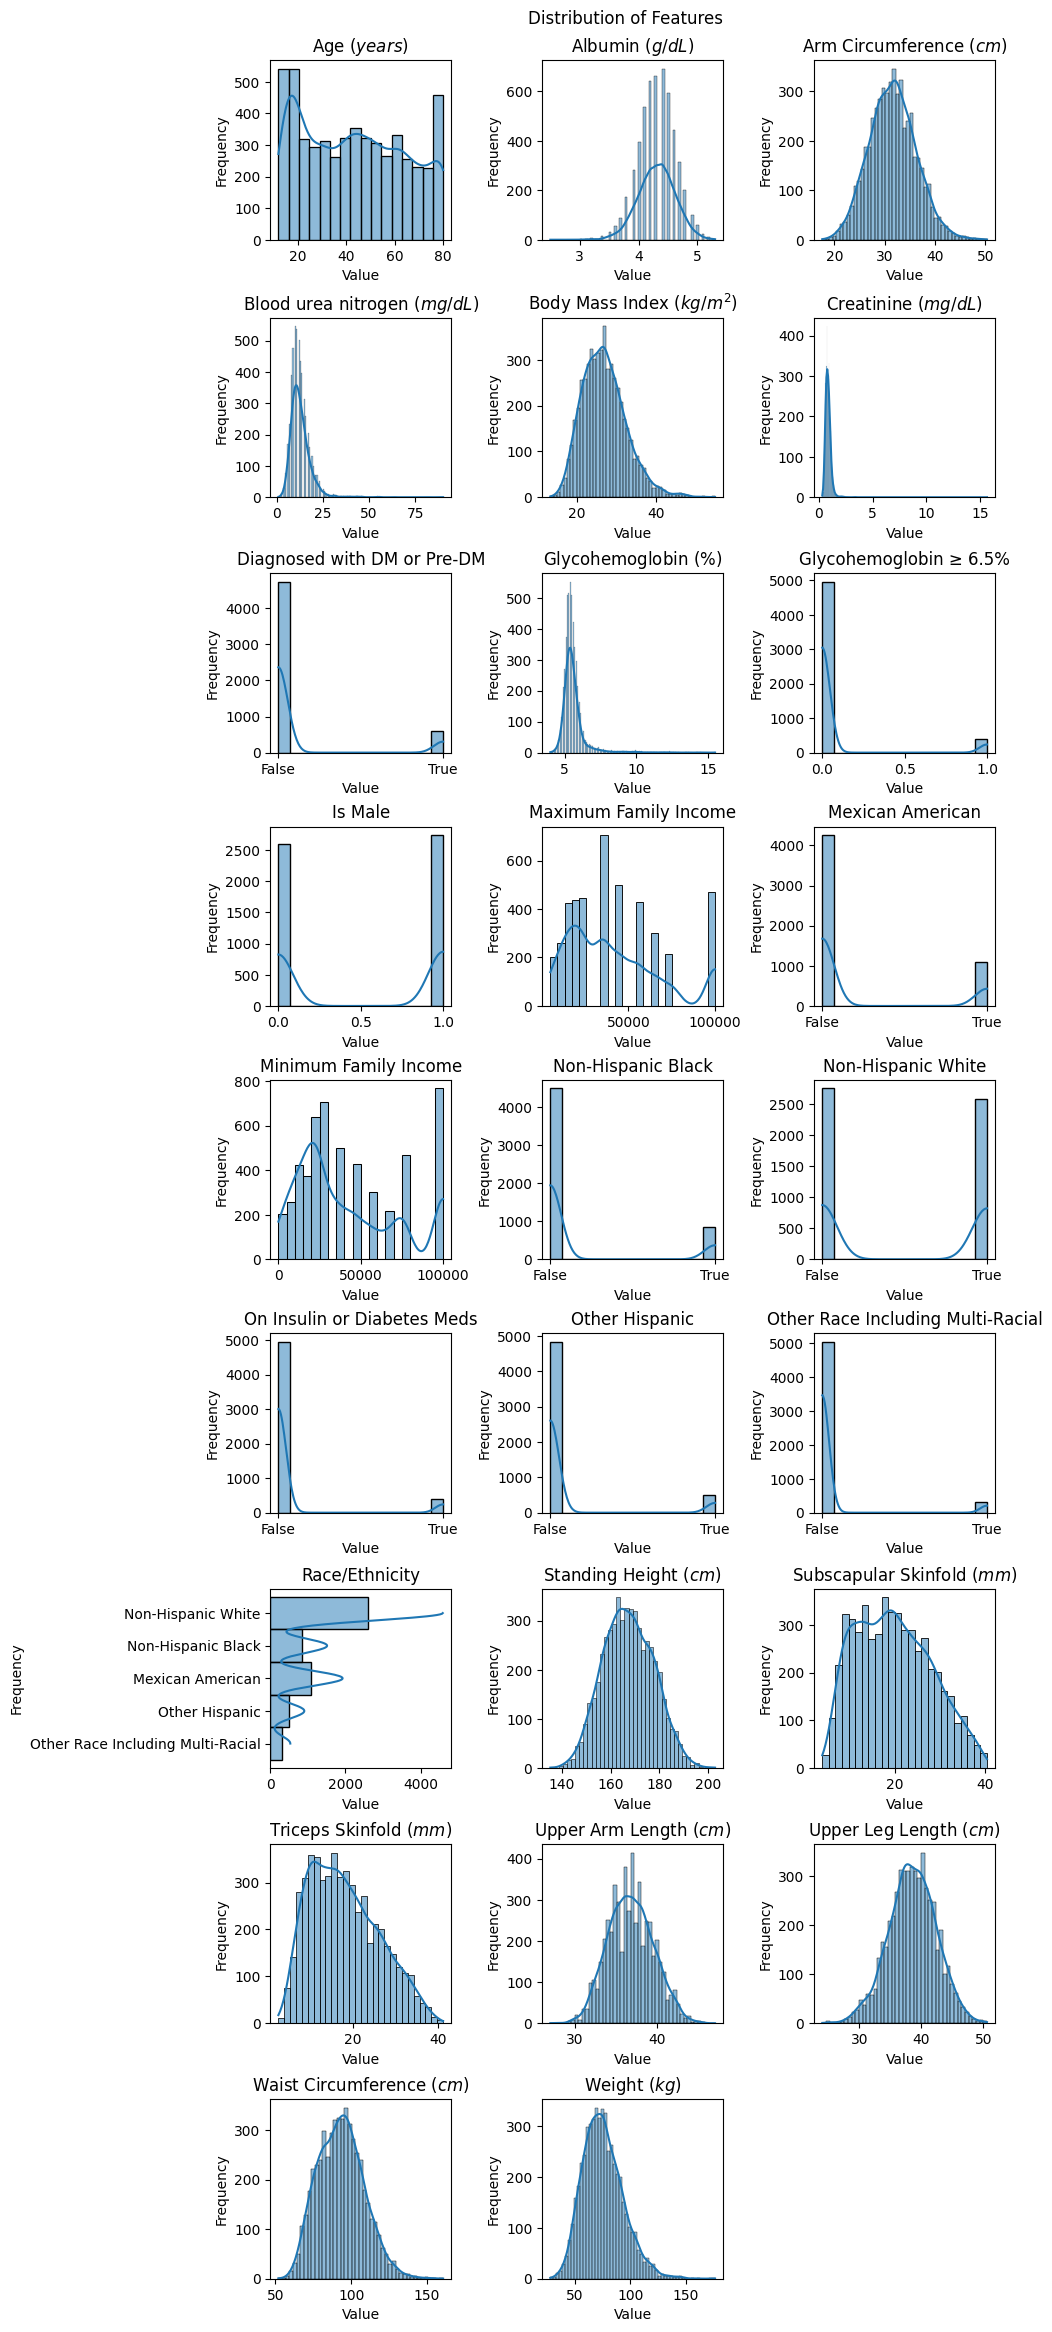

In [35]:
plot_distribution(processed_df)

In [36]:
print(f"Percentage of data with {target}:\n{processed_df[target].mean() * 100}%")

Percentage of data with Glycohemoglobin ≥ 6.5%:
7.186973610331275%


**Normal Distribution:**
- Upper Leg Length ($cm$)
- Upper Arm Length ($cm$)
- Standing Height ($cm$)

**Right-Skewed:**
- Glycohemoglobin ($\%$)
- Weight ($kg$)
- Body Mass Index ($kg/m^2$)
- Arm Circumference ($cm$)
- Waist Circumference ($cm$)
- Triceps Skinfold ($mm$)
- Subscapular Skinfold ($mm$)
- Blood urea nitrogen ($mg/dL$)
- Creatinine ($mg/dL$)

**Left-Skewed:**
- Albumin ($g/dL$)

**Bimodal Distribution:**
- Maximum Family Income
- Minimum Family Income

**Balanced Categorical Distribution:**
- Is Male
- Non-Hispanic White

**Imbalanced Categorical Distribution:**
- Glycohemoglobin ≥ 6.5%
- On Insulin or Diabetes Meds
- Diagnosed with DM or Pre-DM
- Race/Ethnicity
- Mexican American
- Non-Hispanic Black
- Other Hispanic
- Other Race Including Multi-Racial

Since most of the features have skewed distributions, we can consider transforming them to make them more Gaussian-like.

The **target is highly imbalanced** with only about **7.2%** of the data in the **positive** class.<br>
To address this imbalance, we can consider **upsampling the minority** class with synthetic samples.

## Proportion of Target Group in Categorical Features

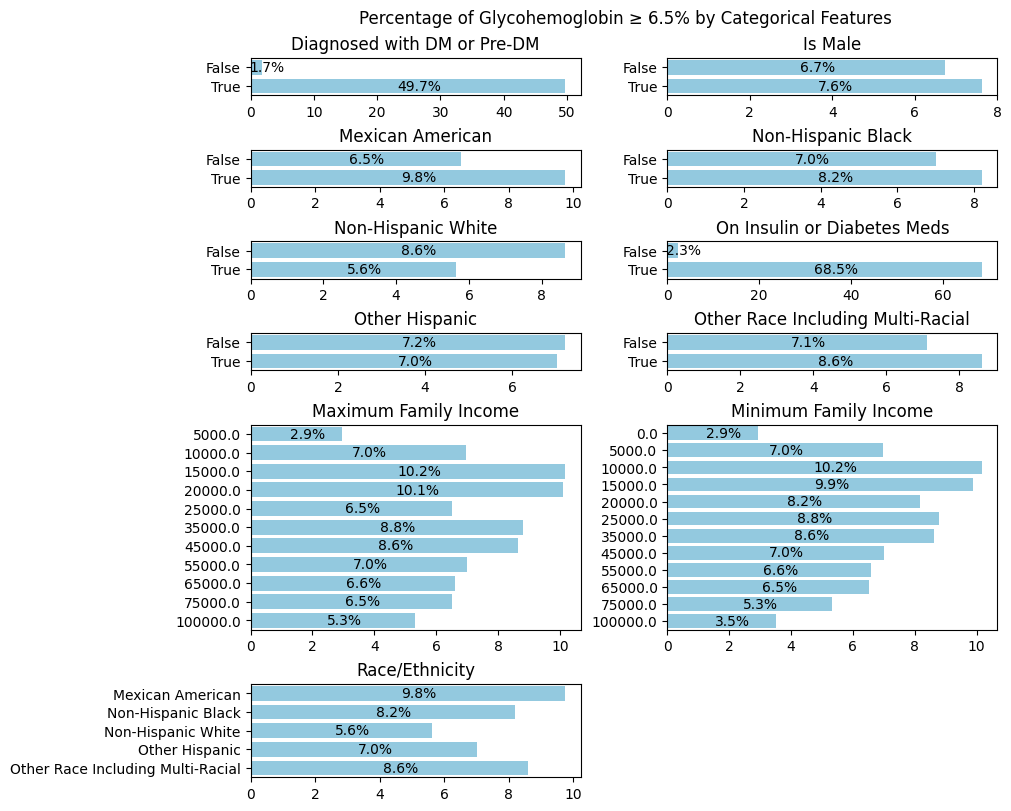

In [37]:
plot_ratio_target_in_categorical_features(processed_df, config)

**Observations:**

**Significantly Higher Prevalence:**
- Individuals diagnosed with DM or Pre-DM, those on insulin or diabetes meds, and individuals of other races (including multi-racial backgrounds) exhibit significantly higher prevalence rates. These factors indicate a strong association with an increased likelihood of diabetes or pre-diabetes.

**Moderately Higher Prevalence:**
- Mexican Americans and Non-Hispanic Blacks show moderately higher prevalence rates. This suggests that these ethnic groups have a relatively higher risk of diabetes or pre-diabetes compared to the reference group.

**Slightly Higher Prevalence:**
- Males, and individuals with certain income levels (around 15000 to 20000) exhibit slightly higher prevalence. While these factors contribute to a higher risk, their impact is less pronounced compared to the significantly higher prevalence categories.

**Explanation:**
- The observed variations in prevalence highlight the importance of factors such as diagnosis status, medication usage, ethnicity, and income levels in influencing the likelihood of diabetes or pre-diabetes. Understanding these associations is crucial for targeted interventions and healthcare strategies aimed at preventing and managing diabetes across diverse populations. Individuals in high-risk groups may benefit from tailored preventive measures and early detection efforts.

## Correlation of Features

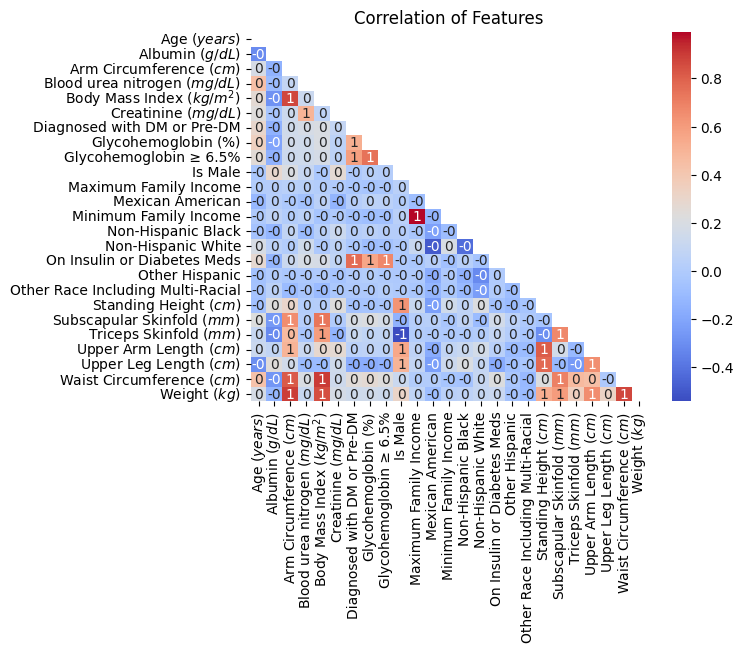

In [38]:
numerical_feats = processed_df.select_dtypes(include=["number", "bool"]).columns
title = "Correlation of Features"
plot_heatmap(
    df=processed_df[numerical_feats].corr(),
    title=title,
    num_dp=0,
)

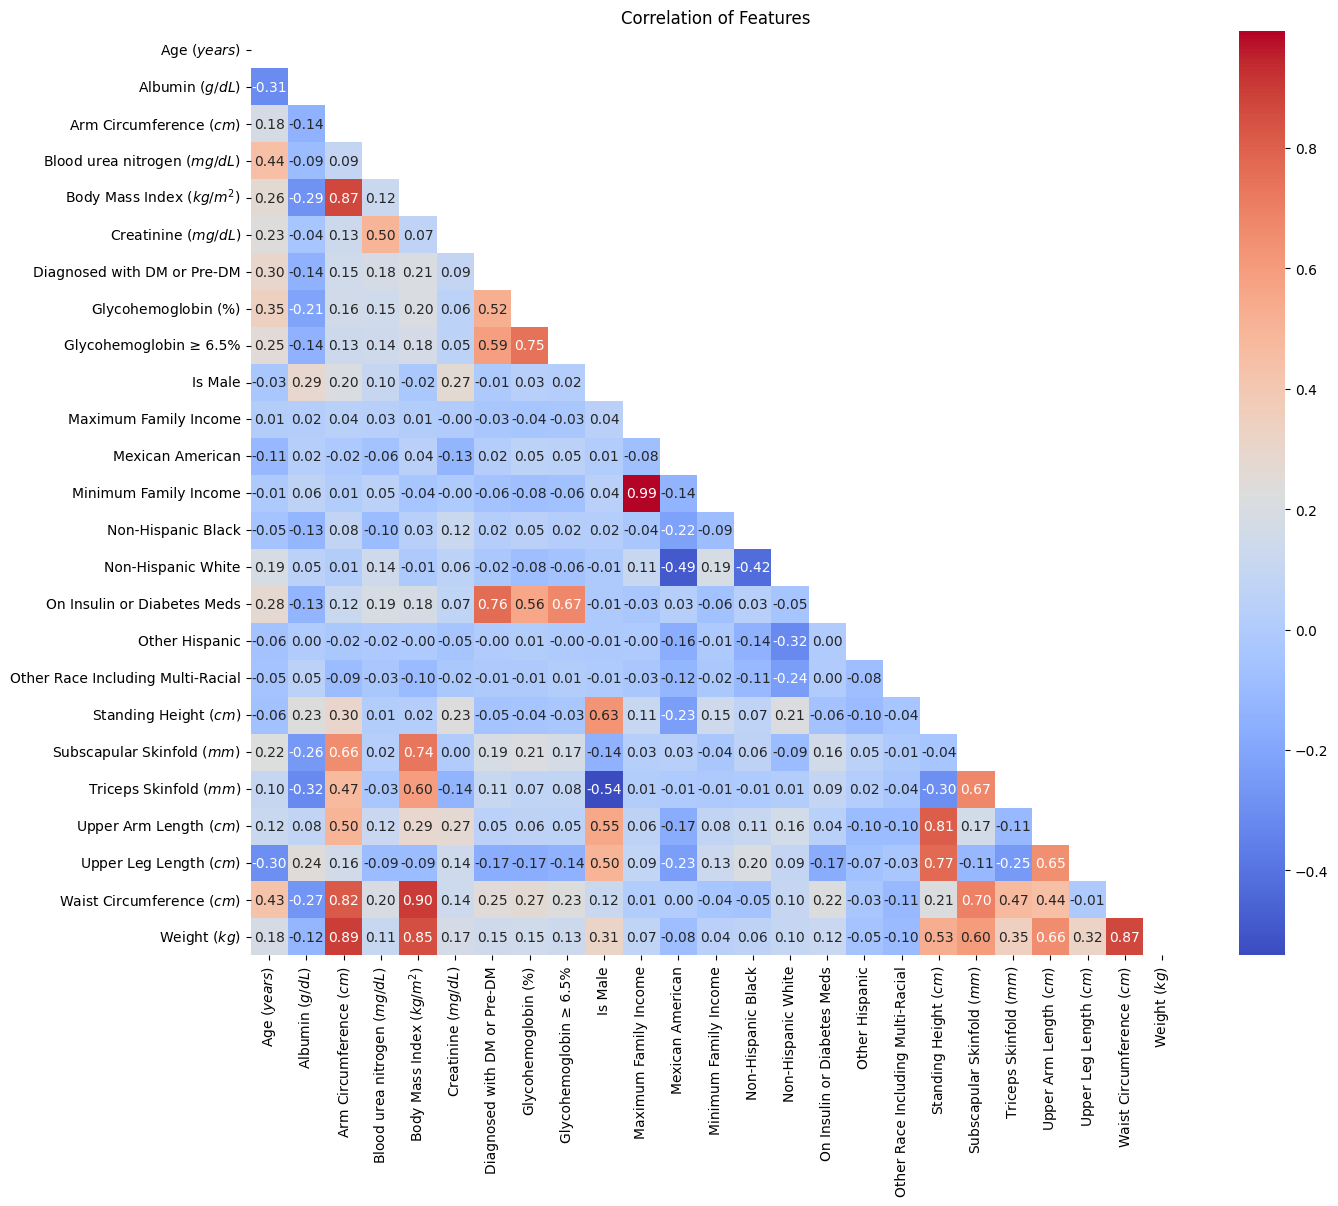

In [39]:
plot_heatmap(
    df=processed_df[numerical_feats].corr(),
    title=title,
    num_dp=2, 
    figsize=(15, 12)
)

## Scale Numerical Features

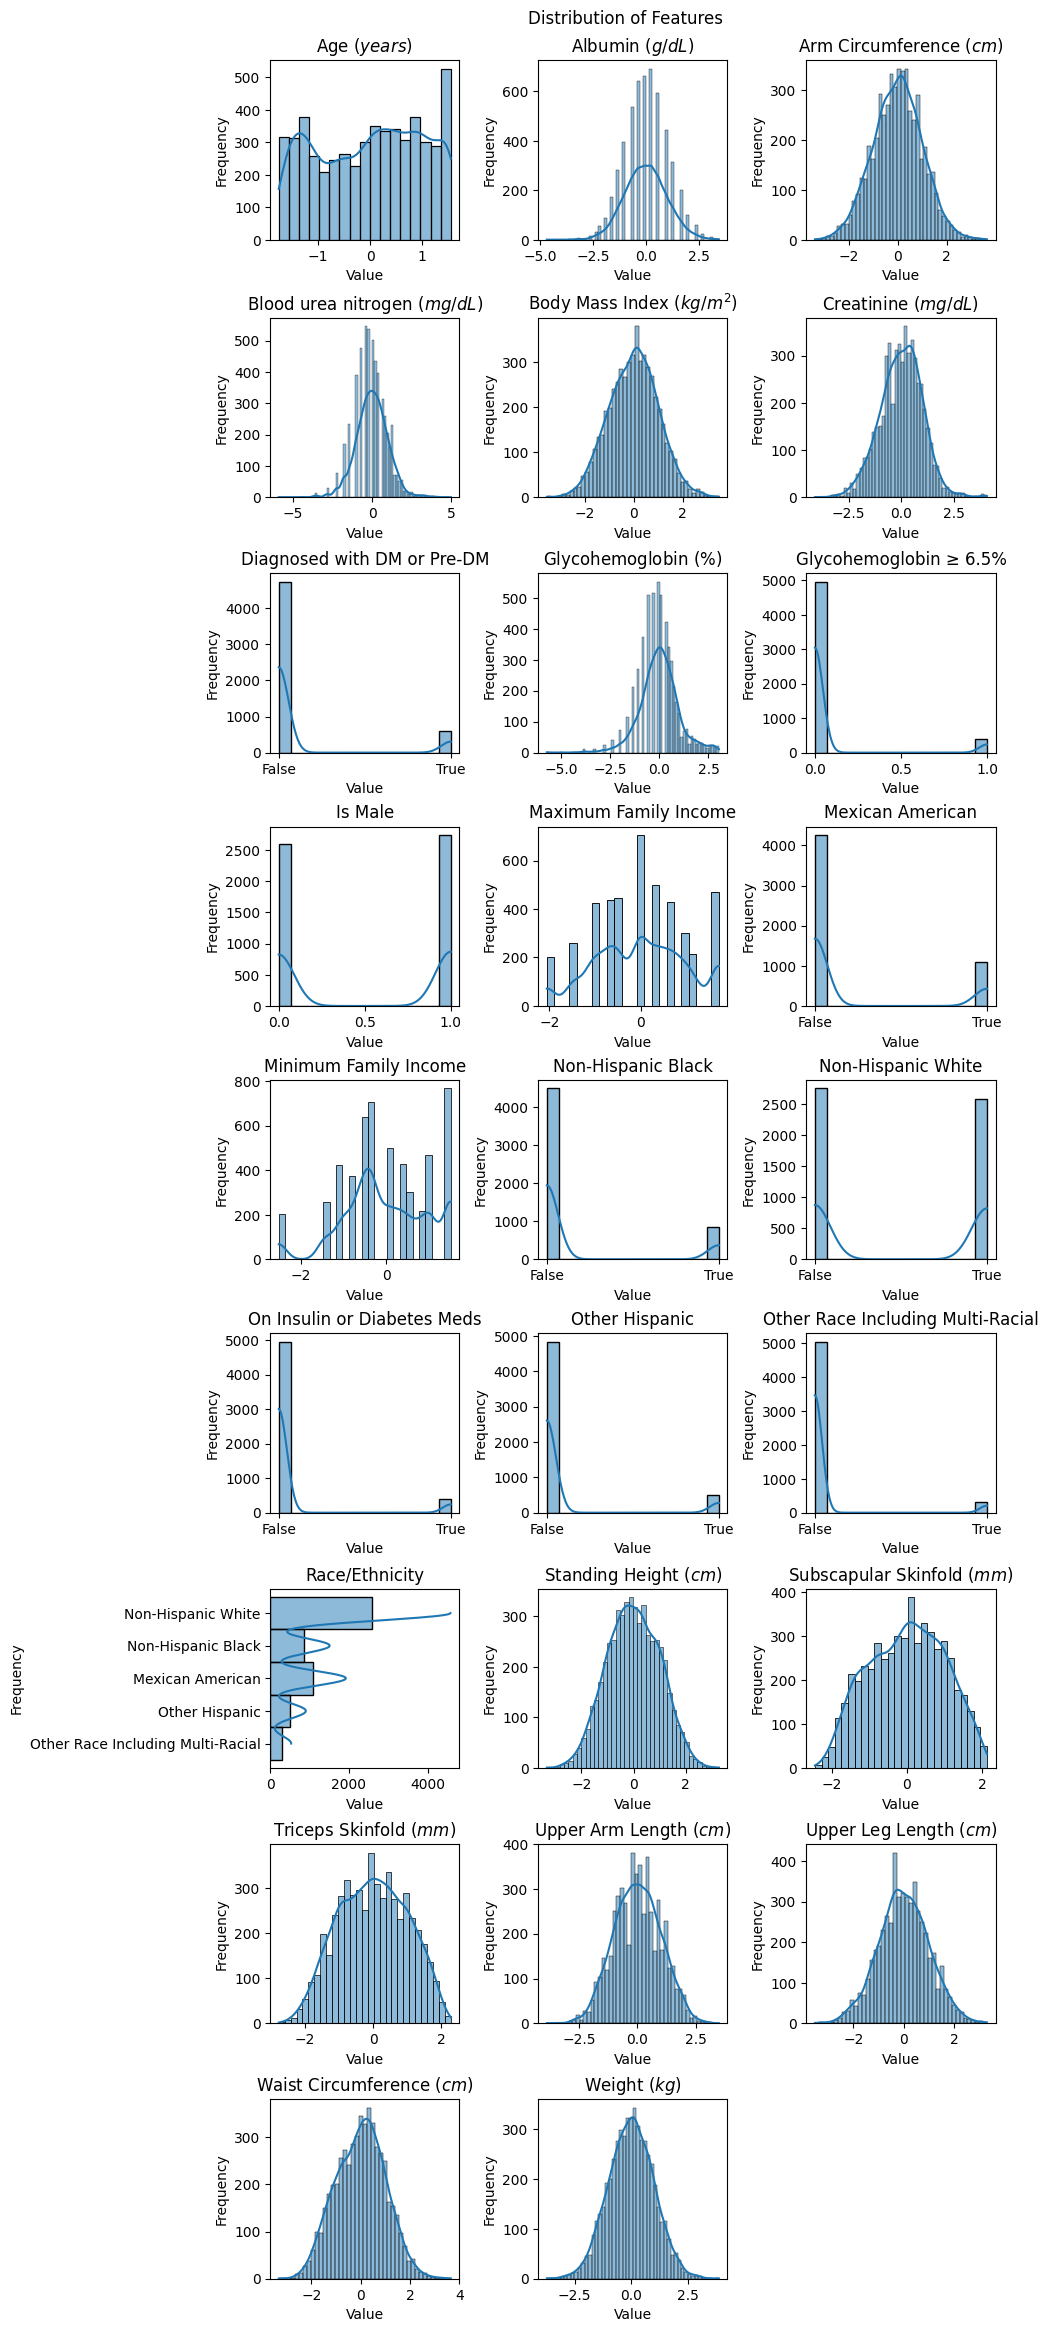

In [40]:
processed_df, _ = scale_numerical_features(processed_df)
plot_distribution(processed_df)

## Upsample Minority Target

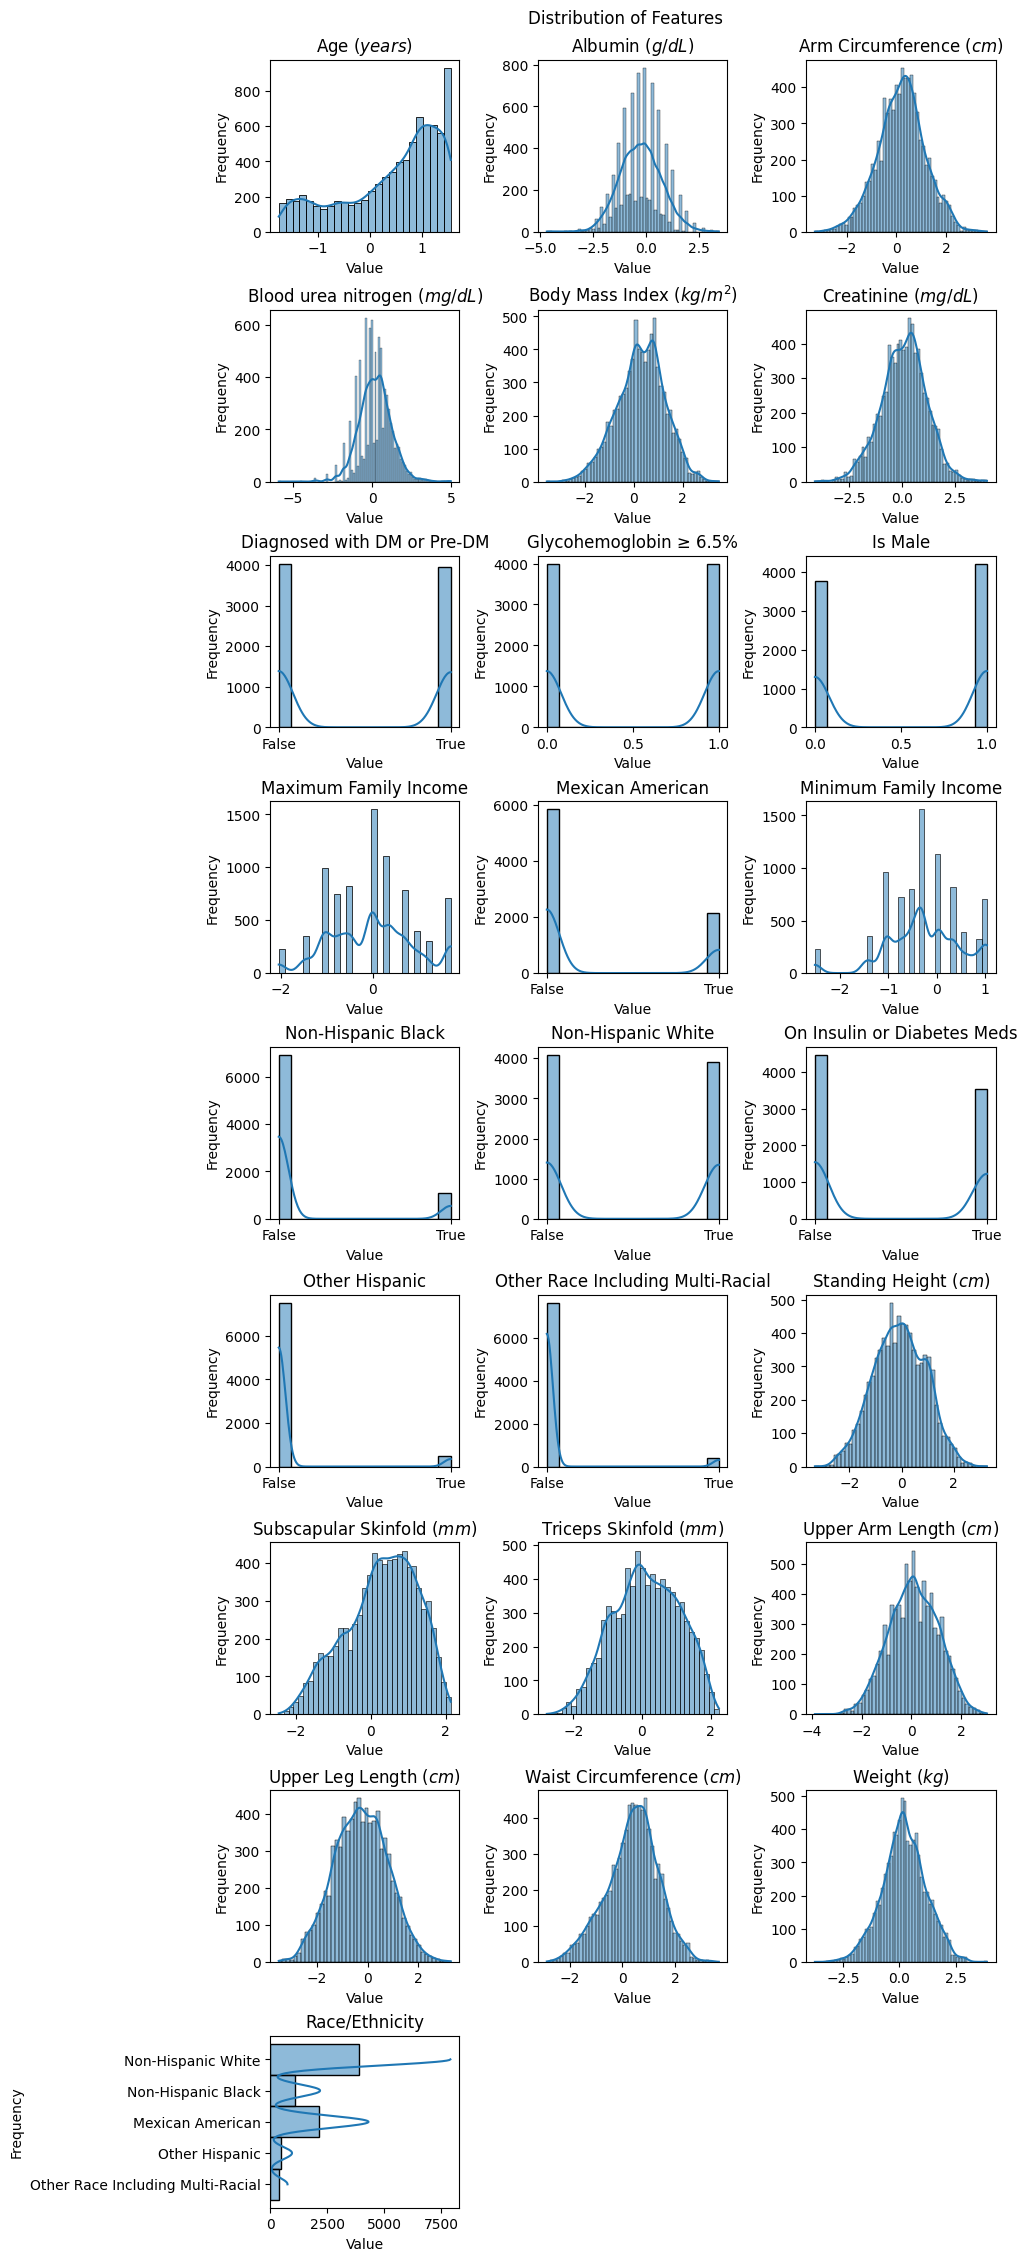

In [41]:
X = processed_df.copy()

nominal_features = X.select_dtypes(exclude=["number", "bool"]).columns.to_list()
for nominal_feature in nominal_features:
    X = X.drop(columns=list(X[nominal_feature].unique()))
    
y = X[config.get("target")]
X = X.drop(columns=[config.get("target"), config.get("feature")], axis=1)

if config.get("imputation_method") != "DN":
    X = X.dropna()
    y = y[X.index]
    X, y = upsample_minority(X, y, config)
    
processed_df = pd.concat([X, y], axis=1)
processed_df = one_hot_encode_features(processed_df, drop_columns=False)
processed_df = sort_columns(processed_df)
features = processed_df.columns
features = features.drop(nominal_features).to_list()
features = features + nominal_features
plot_distribution(processed_df[features], folder_path)

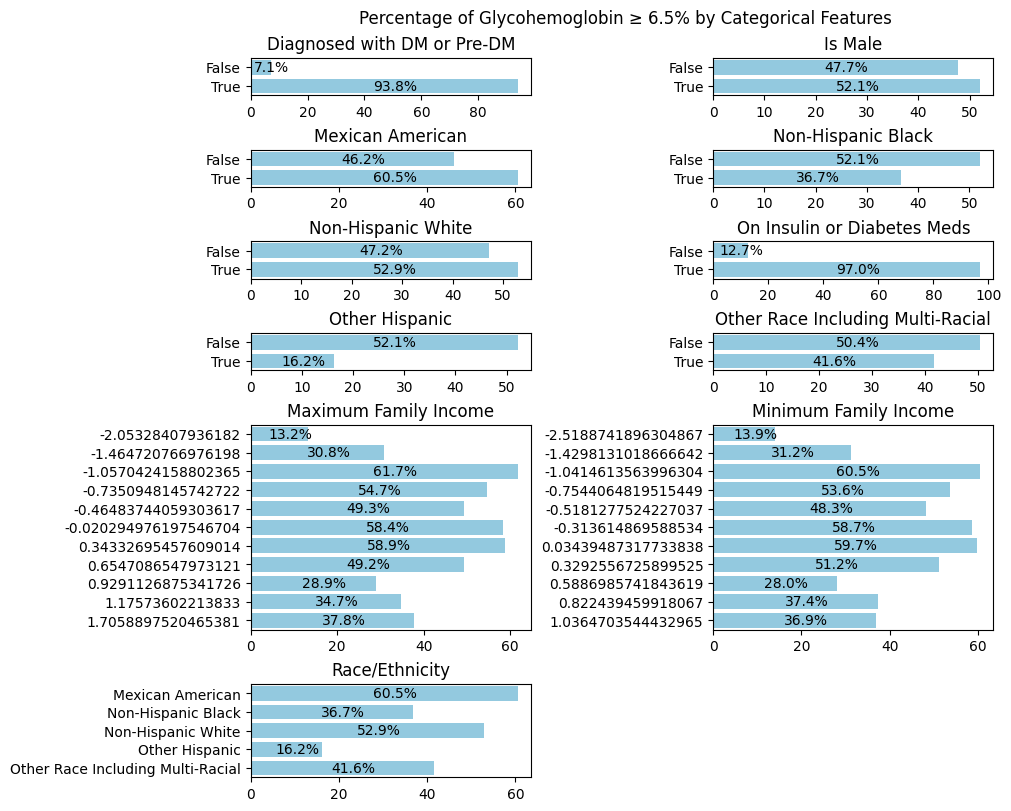

In [42]:
plot_ratio_target_in_categorical_features(processed_df, config, folder_path)

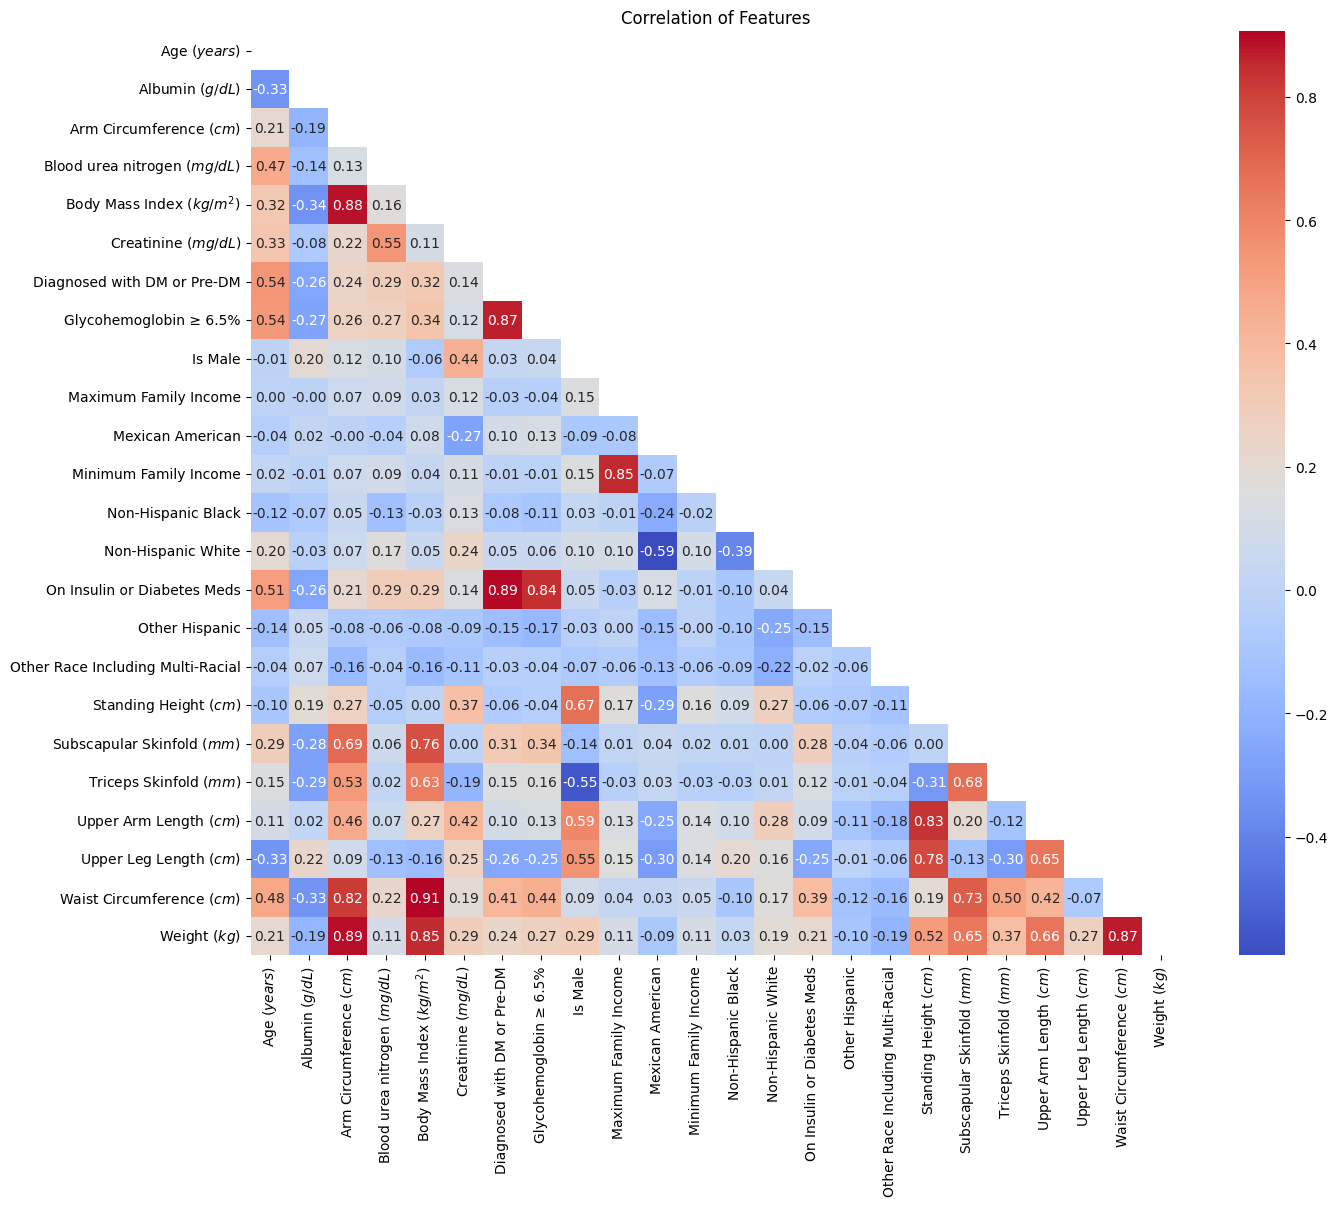

In [43]:
numerical_feats = processed_df.select_dtypes(include=["number", "bool"]).columns
plot_heatmap(
    df=processed_df[numerical_feats].corr(),
    title=title,
    num_dp=2, 
    figsize=(15, 12),
    folder_path=folder_path
)